In [1]:
#Imports
import os
from random import uniform
from pathlib import Path
from nufeb_tools import utils,plot
import pandas as pd
from string import Template
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import r2_score,mean_squared_error
import seaborn as sns
from tqdm import tqdm
from hyperopt import tpe, atpe, fmin,Trials,plotting, STATUS_OK,hp
from joblib import Parallel, delayed, dump,load
import subprocess

In [2]:
test_data = pd.read_excel('/home/jsakkos/nufeb-cyano-e-coli/experimental-data/sucrose-OD-IPTG-sweep recalculated April 2022.xls',sheet_name='data')
from scipy.optimize import curve_fit
def od_func(x):
    """Exponential fit to IPTG vs OD750 experimental data

    Args:
        x (float): IPTG concentration (mM)

    Returns:
        float: Smoothed OD750
    """
    return 0.25482 * np.exp(-x/.06811) + 1.12893
# Smooth OD750 data for fitting
test_data.loc[:,'OD750'] = od_func(test_data.IPTG)

In [3]:
def recompile(alpha,tau,c,alpha2,tau2,c2):
    """Recompile NUFEB with new fitting parameters

    Args:
        alpha ([type]): [description]
        tau ([type]): [description]
        c ([type]): [description]
        alpha2 ([type]): [description]
        tau2 ([type]): [description]
        c2 ([type]): [description]
    """
    #
    filein = open( r'/home/jsakkos/nufeb-cyano-e-coli/templates/fix_bio_kinetics_monod2.txt' )
    #read it
    src = Template( filein.read() )
    #do the substitution
    result = src.safe_substitute({'alpha' : alpha, 'tau' : tau, 'c' : c,'alpha2' : alpha2, 'tau2' : tau2, 'c2' : c2
    })
    with open('/home/jsakkos/NUFEB/src/USER-NUFEB/fix_bio_kinetics_monod.cpp',"w") as f:
       f.writelines(result)
    #Compile NUFEB
    os.chdir(r'/home/jsakkos/NUFEB')
    #os.system('./install.sh --enable-hdf5 > /dev/null')
    subprocess.run(['./install.sh', '--enable-hdf5'], stdout=subprocess.DEVNULL, stderr=subprocess.DEVNULL)
def recompile_clean():
    os.system(r'cp /home/jsakkos/nufeb-cyano-e-coli/templates/fix_bio_kinetics_monod_clean.txt /home/jsakkos/NUFEB/src/USER-NUFEB/fix_bio_kinetics_monod.cpp')
    #Compile NUFEB
    os.chdir(r'/home/jsakkos/NUFEB')
    subprocess.run(['./install.sh', '--enable-hdf5'], stdout=subprocess.DEVNULL, stderr=subprocess.DEVNULL)

In [4]:
def collect_data(folder):
    x = utils.get_data(directory=str(folder))
    Volume = np.prod(x.metadata['Dimensions'])
    CellNum2OD = Volume*1e6/0.3e-8
    Biomass2OD = .2825*Volume*1e18
    temp = pd.concat([x.biomass.cyano.reset_index(drop=True)/Biomass2OD,x.biomass.step.reset_index(drop=True)/60/60*x.timestep,x.avg_con.Sucrose.reset_index(drop=True)],axis=1)
    temp.columns=['OD750','Hours','Sucrose']
    temp['IPTG'] = x.metadata['IPTG']
    return temp

    

In [5]:
growth_data = pd.read_excel('/home/jsakkos/nufeb-cyano-e-coli/experimental-data/Biomass CscB-SPS original strain recalculated April 2022.xlsx',sheet_name='Compiled')
growth_data = growth_data[['Time','OD750']]
growth_data.columns = ['Hours','OD750']
expdf = growth_data.groupby('Hours').mean().reset_index()
recompile_clean()
def mu_objective(params):
    mu = params['mu']
    os.chdir('/home/jsakkos/NUFEB')
    os.system('nufeb-clean')
    print(f'mu: {mu:.2e}')
    text = f'nufeb-seed --n 3 --od 0.3,0 --d 1e-4,1e-4,1e-4 --grid 20 --t 8700 --mucya {mu} --niter 1000'
    os.system(text)
    #Run new simulations
    os.system('/home/jsakkos/par.sh')
    BASE_DIR = Path(f'runs/')
    folders = [path for path in BASE_DIR.iterdir() if path.is_dir()]

    #Extract output

    tmp=Parallel(n_jobs=-1)(delayed(collect_data)(folder) for folder in folders)
    data = pd.concat(tmp,ignore_index=True)
    df = data.groupby('Hours').mean().reset_index()
    sns.lineplot(x='Hours',y='OD750',data=data,color='r')
    sns.scatterplot(x='Hours',y='OD750',data=expdf)
    plt.show()
    r2_value = r2_score(expdf.OD750,np.interp([0,6,12,24],df['Hours'],df['OD750']))
    muERR = mean_squared_error(expdf.OD750,np.interp([0,6,12,24],df['Hours'],df['OD750']),sample_weight=expdf.OD750,squared=False)
    print(f'R2 = {r2_value:.3f}')
    return {'loss' :muERR,'status':STATUS_OK}

mu: 7.33e-06                                                                                                                                                           
  0%|                                                                                                                           | 0/25 [00:00<?, ?trial/s, best loss=?]

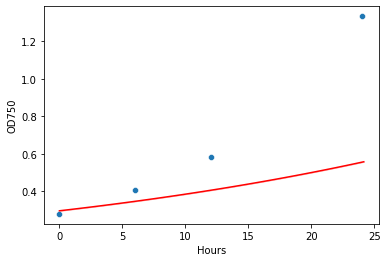

R2 = 0.040                                                                                                                                                             
mu: 1.69e-05                                                                                                                                                           
  4%|███▉                                                                                             | 1/25 [00:11<04:05, 10.23s/trial, best loss: 0.5629180644487428]

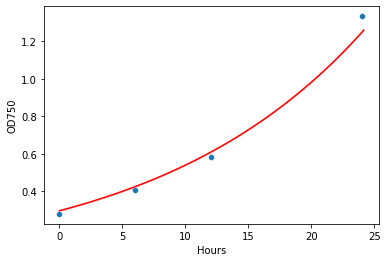

R2 = 0.987                                                                                                                                                             
mu: 1.27e-05                                                                                                                                                           
  8%|███████▋                                                                                        | 2/25 [00:20<03:44,  9.74s/trial, best loss: 0.06333043834478655]

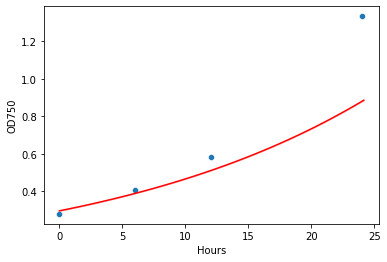

R2 = 0.682                                                                                                                                                             
mu: 7.66e-06                                                                                                                                                           
 12%|███████████▌                                                                                    | 3/25 [00:29<03:28,  9.49s/trial, best loss: 0.06333043834478655]

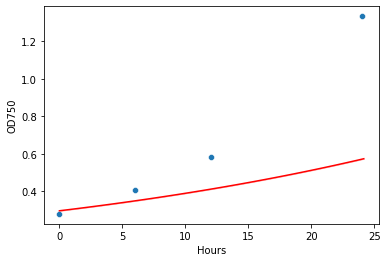

R2 = 0.080                                                                                                                                                             
mu: 7.96e-05                                                                                                                                                           
 16%|███████████████▎                                                                                | 4/25 [00:38<03:16,  9.34s/trial, best loss: 0.06333043834478655]

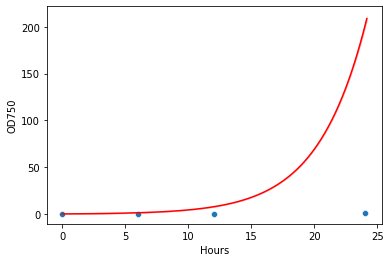

R2 = -59271.948                                                                                                                                                        
mu: 2.05e-05                                                                                                                                                           
 20%|███████████████████▏                                                                            | 5/25 [01:40<09:26, 28.32s/trial, best loss: 0.06333043834478655]

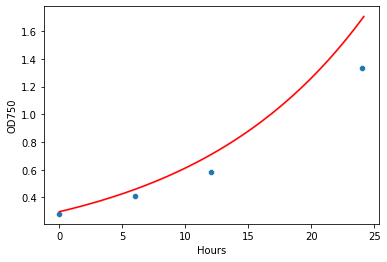

R2 = 0.786                                                                                                                                                             
mu: 1.74e-05                                                                                                                                                           
 24%|███████████████████████                                                                         | 6/25 [01:50<06:58, 22.00s/trial, best loss: 0.06333043834478655]

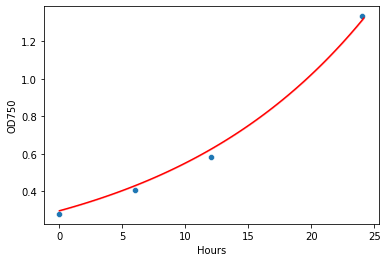

R2 = 0.996                                                                                                                                                             
mu: 1.33e-05                                                                                                                                                           
 28%|██████████████████████████▌                                                                    | 7/25 [01:59<05:20, 17.83s/trial, best loss: 0.027533606958113015]

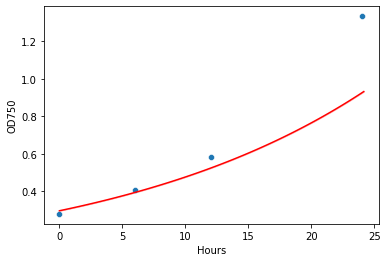

R2 = 0.744                                                                                                                                                             
mu: 5.43e-05                                                                                                                                                           
 32%|██████████████████████████████▍                                                                | 8/25 [02:08<04:13, 14.93s/trial, best loss: 0.027533606958113015]

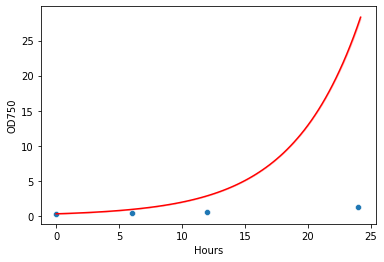

R2 = -1031.306                                                                                                                                                         
mu: 4.73e-05                                                                                                                                                           
 36%|██████████████████████████████████▏                                                            | 9/25 [02:25<04:09, 15.61s/trial, best loss: 0.027533606958113015]

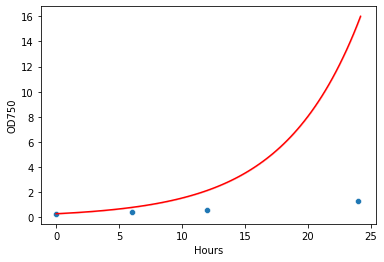

R2 = -307.065                                                                                                                                                          
mu: 1.21e-04                                                                                                                                                           
 40%|█████████████████████████████████████▌                                                        | 10/25 [02:39<03:44, 14.95s/trial, best loss: 0.027533606958113015]

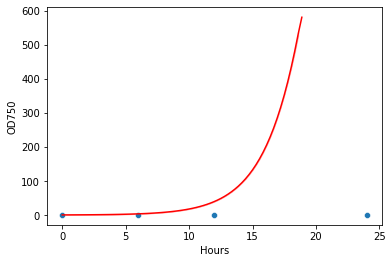

R2 = -505941.272                                                                                                                                                       
mu: 3.05e-05                                                                                                                                                           
 44%|█████████████████████████████████████████▎                                                    | 11/25 [04:44<11:25, 48.94s/trial, best loss: 0.027533606958113015]

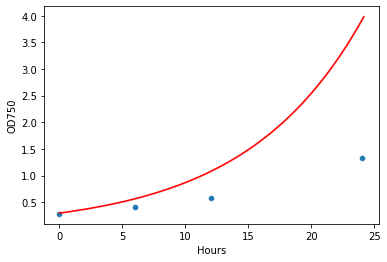

R2 = -9.395                                                                                                                                                            
mu: 9.58e-06                                                                                                                                                           
 48%|█████████████████████████████████████████████                                                 | 12/25 [04:55<08:02, 37.10s/trial, best loss: 0.027533606958113015]

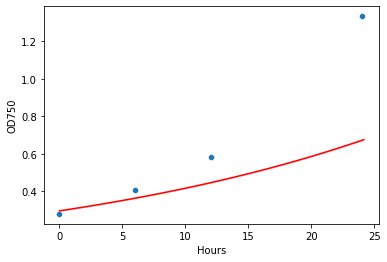

R2 = 0.313                                                                                                                                                             
mu: 1.92e-05                                                                                                                                                           
 52%|████████████████████████████████████████████████▉                                             | 13/25 [05:03<05:41, 28.50s/trial, best loss: 0.027533606958113015]

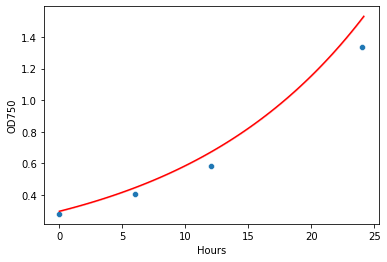

R2 = 0.937                                                                                                                                                             
mu: 5.80e-05                                                                                                                                                           
 56%|████████████████████████████████████████████████████▋                                         | 14/25 [05:12<04:09, 22.65s/trial, best loss: 0.027533606958113015]

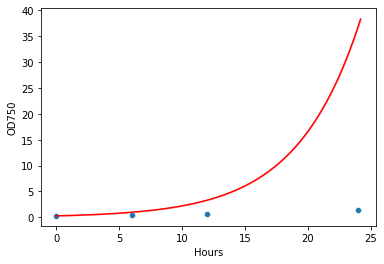

R2 = -1926.841                                                                                                                                                         
mu: 2.18e-05                                                                                                                                                           
 60%|████████████████████████████████████████████████████████▍                                     | 15/25 [05:32<03:37, 21.79s/trial, best loss: 0.027533606958113015]

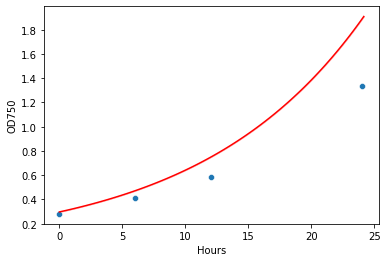

R2 = 0.497                                                                                                                                                             
mu: 1.31e-05                                                                                                                                                           
 64%|████████████████████████████████████████████████████████████▏                                 | 16/25 [05:42<02:43, 18.12s/trial, best loss: 0.027533606958113015]

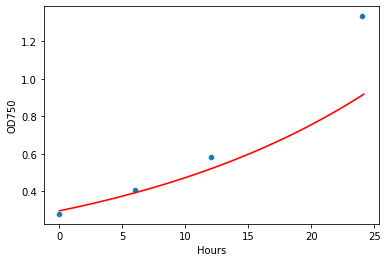

R2 = 0.726                                                                                                                                                             
mu: 1.92e-05                                                                                                                                                           
 68%|███████████████████████████████████████████████████████████████▉                              | 17/25 [05:51<02:03, 15.38s/trial, best loss: 0.027533606958113015]

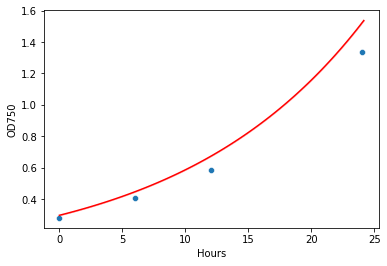

R2 = 0.934                                                                                                                                                             
mu: 2.16e-05                                                                                                                                                           
 72%|███████████████████████████████████████████████████████████████████▋                          | 18/25 [06:00<01:34, 13.51s/trial, best loss: 0.027533606958113015]

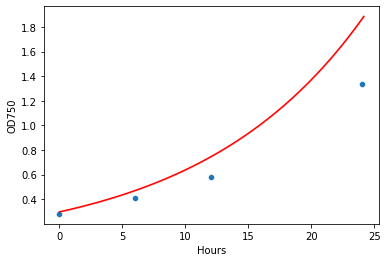

R2 = 0.536                                                                                                                                                             
mu: 5.10e-05                                                                                                                                                           
 76%|███████████████████████████████████████████████████████████████████████▍                      | 19/25 [06:09<01:13, 12.25s/trial, best loss: 0.027533606958113015]

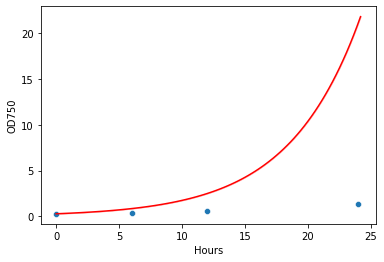

R2 = -595.438                                                                                                                                                          
mu: 1.94e-05                                                                                                                                                           
 80%|███████████████████████████████████████████████████████████████████████████▏                  | 20/25 [06:25<01:06, 13.22s/trial, best loss: 0.027533606958113015]

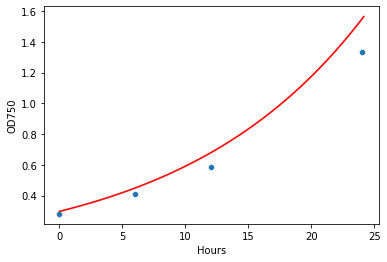

R2 = 0.915                                                                                                                                                             
mu: 1.71e-05                                                                                                                                                           
 84%|██████████████████████████████████████████████████████████████████████████████▉               | 21/25 [06:34<00:48, 12.00s/trial, best loss: 0.027533606958113015]

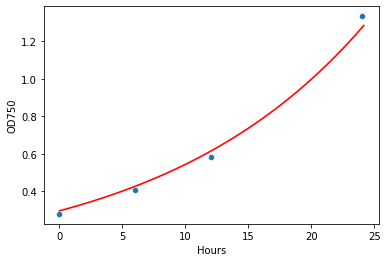

R2 = 0.992                                                                                                                                                             
mu: 2.71e-05                                                                                                                                                           
 88%|██████████████████████████████████████████████████████████████████████████████████▋           | 22/25 [06:43<00:33, 11.11s/trial, best loss: 0.027533606958113015]

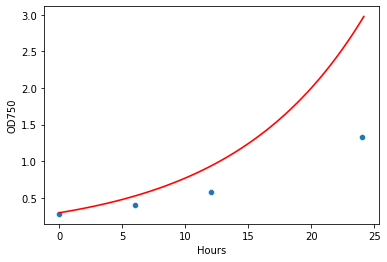

R2 = -3.033                                                                                                                                                            
mu: 1.62e-05                                                                                                                                                           
 92%|██████████████████████████████████████████████████████████████████████████████████████▍       | 23/25 [06:53<00:21, 10.69s/trial, best loss: 0.027533606958113015]

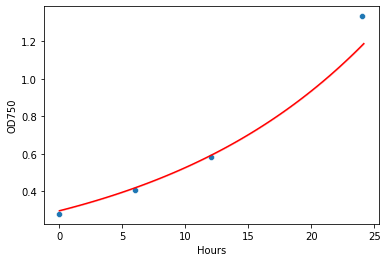

R2 = 0.962                                                                                                                                                             
mu: 1.86e-05                                                                                                                                                           
 96%|██████████████████████████████████████████████████████████████████████████████████████████▏   | 24/25 [07:02<00:10, 10.20s/trial, best loss: 0.027533606958113015]

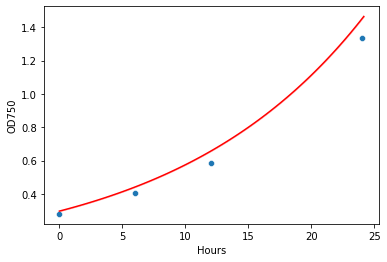

R2 = 0.970                                                                                                                                                             
100%|██████████████████████████████████████████████████████████████████████████████████████████████| 25/25 [07:10<00:00, 17.22s/trial, best loss: 0.027533606958113015]
{'mu': 1.7442783292849497e-05}


In [17]:
mu_space = {
    'mu' : hp.loguniform('mu', -12, -9),

}
mu_trials = Trials()


mu_best = fmin(
    fn=mu_objective, # Objective Function to optimize
    space=mu_space, # Hyperparameter's Search Space
    algo=atpe.suggest, # Optimization algorithm
    max_evals=25,
    trials = mu_trials # Number of optimization attempts
)

print(mu_best)

In [12]:
np.exp(-5)

0.006737946999085467

In [15]:
np.log(10**(-4))

-9.210340371976182

In [5]:
def od_func(a,tau,c,iptg):
    return a*np.exp(-iptg/tau)+c
def suc_func(a2,tau2,c2,iptg):
    return -a2*np.exp(-iptg/tau2)+c2

In [7]:
def objective(params):
    a,tau,c,a2,tau2,c2 = params["a"], params["tau"],params["c"],params["a2"], params["tau2"],params["c2"]
    if all(od_func(a,tau,c,iptg) < 0 for iptg in test_data.IPTG):
        return {'loss' : 100,'status': STATUS_OK}
    elif all(od_func(a,tau,c,iptg) > 2 for iptg in test_data.IPTG):
        return {'loss' : 100,'status': STATUS_OK}
    elif all(suc_func(a2,tau2,c2,iptg) <=0 for iptg in test_data.IPTG):
        return {'loss' : 100,'status': STATUS_OK}
    elif all(suc_func(a2,tau2,c2,iptg) >1 for iptg in test_data.IPTG):
        return {'loss' : 100,'status': STATUS_OK}
    recompile(a,tau,c,a2,tau2,c2)
    #Clean old simulations
    os.chdir('/home/jsakkos/NUFEB')
    os.system('nufeb-clean')
    #Seed new simulations
    for iptg in test_data.IPTG:
        text = f'nufeb-seed --n 3 --cells 100,0 --d 1e-4,1e-4,1e-4 --grid 20 --t 8700 --mucya 1.89e-5 --iptg {iptg} --niter 1'
        os.system(text)
    #Run new simulations
    os.system('/home/jsakkos/par.sh')
    BASE_DIR = Path(f'runs/')
    folders = [path for path in BASE_DIR.iterdir() if path.is_dir()]

    #Extract output

    tmp=Parallel(n_jobs=-1)(delayed(collect_data)(folder) for folder in folders)
    data = pd.concat(tmp,ignore_index=True)
    df = data.loc[(data.Hours == data.Hours.iloc[-1])]
    df = df.sort_values(by='IPTG')
    df = df.reset_index()
    #save in progress plot
    f, ax = plt.subplots(ncols=2)
    ax[0].set_title('Sucrose')
    ax[0].plot(test_data.IPTG,test_data.Sucrose,marker='o')
    sns.lineplot(x='IPTG',y='Sucrose',ax=ax[0],data=df)
    ax[1].set_title('OD750')
    ax[1].plot(test_data.IPTG,test_data.OD750,marker='o')
    sns.lineplot(x='IPTG',y='OD750',ax=ax[1],data=df)
    f.tight_layout()
    plt.show()

    #Compare output with experimental data via RMSE
    temp = df.groupby('IPTG').mean().reset_index()
    if len(test_data.OD750)==len(temp.OD750):
        ODerr  = mean_squared_error(test_data.OD750,temp.OD750,sample_weight=test_data.OD750,squared=False)
    else:
        print(test_data.OD750,temp.OD750)
    if len(test_data.Sucrose)==len(temp.Sucrose):
        SUCerr = mean_squared_error(test_data.Sucrose,temp.Sucrose,sample_weight=test_data.Sucrose,squared=False)
    else:
        print(test_data.Sucrose,temp.Sucrose)
    return {'loss' : abs(ODerr+SUCerr),'status': STATUS_OK}
def od_objective(params):
    a,tau,c = params["a"], params["tau"],params["c"]
    if all(od_func(a,tau,c,iptg) < 0 for iptg in test_data.IPTG):
        return {'loss' : 100,'status': STATUS_OK}
    elif all(od_func(a,tau,c,iptg) > 2 for iptg in test_data.IPTG):
        return {'loss' : 100,'status': STATUS_OK}

    recompile(a,tau,c,0,1,0)
    #Clean old simulations
    os.chdir('/home/jsakkos/NUFEB')
    os.system('nufeb-clean')
    #Seed new simulations
    for iptg in test_data.IPTG:
        text = f'nufeb-seed --n 3 --cells 100,0 --d 1e-4,1e-4,1e-4 --grid 20 --t 8700 --mucya 1.89e-5 --iptg {iptg} --niter 1'
        os.system(text)
    #Run new simulations
    os.system('/home/jsakkos/par.sh')
    BASE_DIR = Path(f'runs/')
    folders = [path for path in BASE_DIR.iterdir() if path.is_dir()]

    #Extract output

    tmp=Parallel(n_jobs=-1)(delayed(collect_data)(folder) for folder in folders)
    data = pd.concat(tmp,ignore_index=True)
    df = data.loc[(data.Hours == data.Hours.iloc[-1])]
    df = df.sort_values(by='IPTG')
    df = df.reset_index()
    #save in progress plot
    f, ax = plt.subplots()
    ax.set_title('OD750')
    ax.plot(test_data.IPTG,test_data.OD750,marker='o')
    sns.lineplot(x='IPTG',y='OD750',ax=ax,data=df)
    f.tight_layout()
    plt.show()

    #Compare output with experimental data via RMSE
    temp = df.groupby('IPTG').mean().reset_index()
    if len(test_data.OD750)==len(temp.OD750):
        ODerr  = mean_squared_error(test_data.OD750,temp.OD750,sample_weight=test_data.OD750,squared=False)
    else:
        print(test_data.OD750,temp.OD750)
    return {'loss' : ODerr,'status': STATUS_OK}
def suc_objective(params):
    a,tau,c,a2,tau2,c2 = params["a"], params["tau"],params["c"],params["a2"], params["tau2"],params["c2"]

    if all(suc_func(a2,tau2,c2,iptg) <=0 for iptg in test_data.IPTG):
        return {'loss' : 100,'status': STATUS_OK}
    elif all(suc_func(a2,tau2,c2,iptg) >1 for iptg in test_data.IPTG):
        return {'loss' : 100,'status': STATUS_OK}
    recompile(a,tau,c,a2,tau2,c2)
    #Clean old simulations
    os.chdir('/home/jsakkos/NUFEB')
    os.system('nufeb-clean')
    #Seed new simulations
    for iptg in test_data.IPTG:
        text = f'nufeb-seed --n 3 --cells 100,0 --d 1e-4,1e-4,1e-4 --grid 20 --t 8700 --mucya 1.89e-5 --iptg {iptg} --niter 1'
        os.system(text)
    #Run new simulations
    os.system('/home/jsakkos/par.sh')
    BASE_DIR = Path(f'runs/')
    folders = [path for path in BASE_DIR.iterdir() if path.is_dir()]

    #Extract output

    tmp=Parallel(n_jobs=-1)(delayed(collect_data)(folder) for folder in folders)
    data = pd.concat(tmp,ignore_index=True)
    df = data.loc[(data.Hours == data.Hours.iloc[-1])]
    df = df.sort_values(by='IPTG')
    df = df.reset_index()
    #save in progress plot
    f, ax = plt.subplots()
    ax.set_title('Sucrose')
    ax.plot(test_data.IPTG,test_data.Sucrose,marker='o')
    sns.lineplot(x='IPTG',y='Sucrose',ax=ax,data=df)
    f.tight_layout()
    plt.show()

    #Compare output with experimental data via RMSE
    temp = df.groupby('IPTG').mean().reset_index()
    if len(test_data.Sucrose)==len(temp.Sucrose):
        SUCerr = mean_squared_error(test_data.Sucrose,temp.Sucrose,sample_weight=test_data.Sucrose,squared=False)
    else:
        print(test_data.Sucrose,temp.Sucrose)
    return {'loss' : SUCerr,'status': STATUS_OK}

ERROR! Session/line number was not unique in database. History logging moved to new session 28


In [12]:
space = {
    'a' : hp.uniform('a', 1e-3, 1e0),
    'tau' : hp.uniform('tau',1e-3,1e-1),
    'c' : hp.uniform('c',1e-3,1e1),
    'a2' : hp.uniform('a2', 1e-3, 1e1),
    'tau2' : hp.uniform('tau2',1e-3,1e-1),
    'c2' : hp.uniform('c2',1e-3,1e1),
}


#trials = Trials()

#best = fmin(
#    fn=objective, # Objective Function to optimize
#    space=space, # Hyperparameter's Search Space
#    algo=tpe.suggest, # Optimization algorithm
#    max_evals=1000,
#    trials = trials # Number of optimization attempts
#)

#print(best)

  2%|█▉                                                                                                           | 9/500 [00:01<01:08,  7.14trial/s, best loss: 100.0]

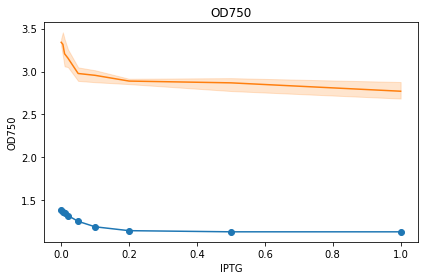

  2%|█▊                                                                                           | 10/500 [01:09<2:51:50, 21.04s/trial, best loss: 1.8125704626368568]

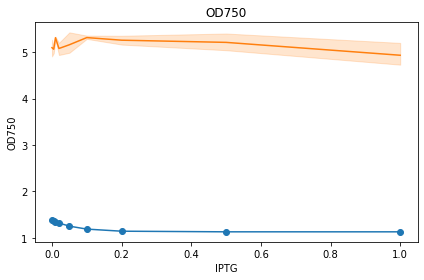

  2%|██                                                                                           | 11/500 [02:16<4:47:34, 35.29s/trial, best loss: 1.8125704626368568]

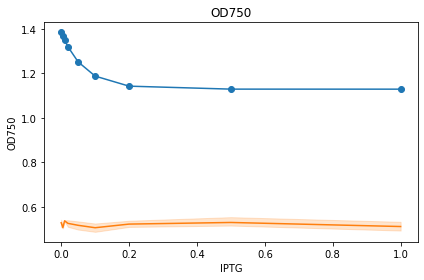

  2%|██▏                                                                                          | 12/500 [03:17<5:50:54, 43.14s/trial, best loss: 0.7433580115346081]

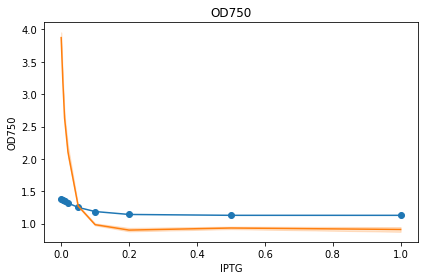

  3%|██▍                                                                                          | 13/500 [04:23<6:46:10, 50.04s/trial, best loss: 0.7433580115346081]

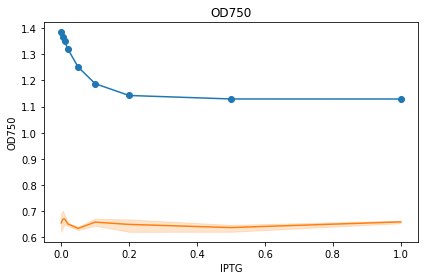

  3%|██▌                                                                                          | 14/500 [05:27<7:19:00, 54.20s/trial, best loss: 0.6119414578043262]

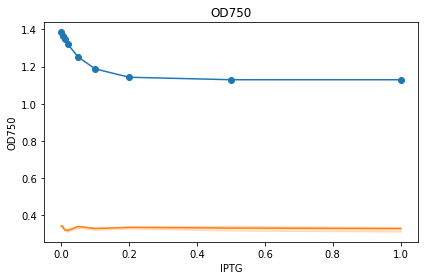

  3%|██▊                                                                                          | 15/500 [06:29<7:37:53, 56.65s/trial, best loss: 0.6119414578043262]

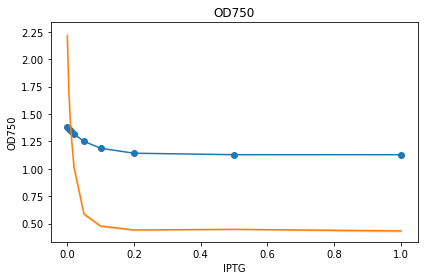

  3%|██▉                                                                                          | 16/500 [07:33<7:52:40, 58.60s/trial, best loss: 0.5951759739464675]

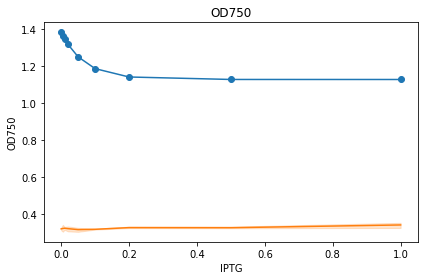

  3%|███▏                                                                                         | 17/500 [08:34<7:59:11, 59.53s/trial, best loss: 0.5951759739464675]

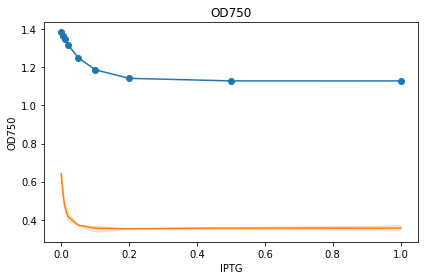

  4%|███▎                                                                                         | 18/500 [09:37<8:07:07, 60.64s/trial, best loss: 0.5951759739464675]

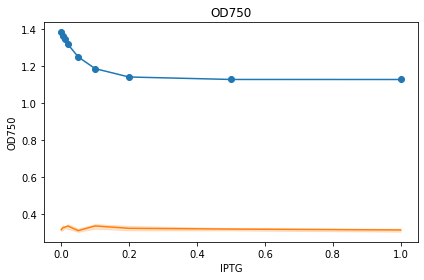

  4%|███▉                                                                                         | 21/500 [10:40<4:00:08, 30.08s/trial, best loss: 0.5951759739464675]

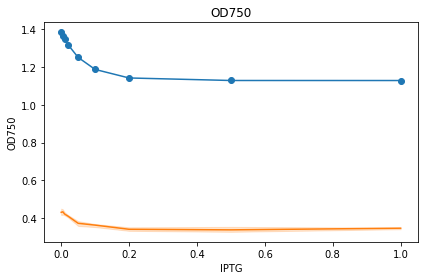

  4%|████                                                                                         | 22/500 [11:43<5:17:18, 39.83s/trial, best loss: 0.5951759739464675]

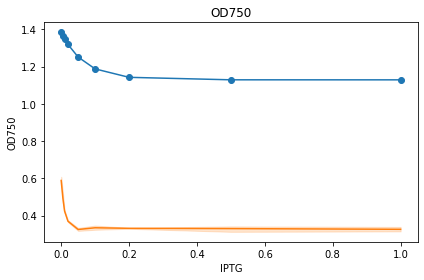

  5%|████▍                                                                                        | 24/500 [12:45<4:18:00, 32.52s/trial, best loss: 0.5951759739464675]

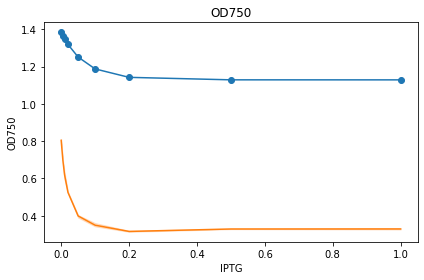

  5%|████▋                                                                                        | 25/500 [13:46<5:25:45, 41.15s/trial, best loss: 0.5951759739464675]

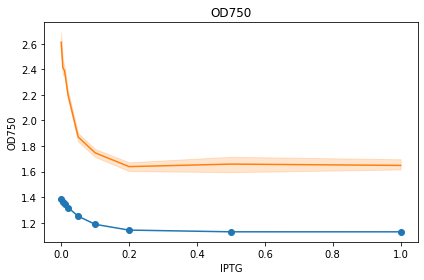

  5%|████▊                                                                                        | 26/500 [14:50<6:19:12, 48.00s/trial, best loss: 0.5951759739464675]

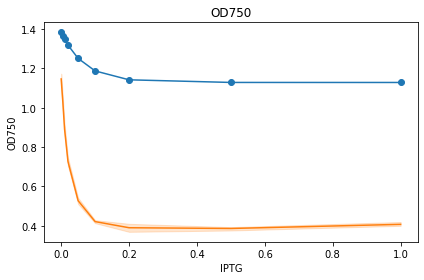

  5%|█████                                                                                        | 27/500 [15:52<6:51:07, 52.15s/trial, best loss: 0.5951759739464675]

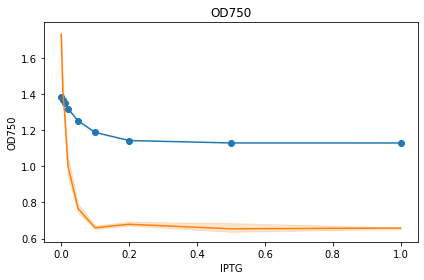

  6%|█████▊                                                                                        | 31/500 [16:54<2:28:30, 19.00s/trial, best loss: 0.386890357069524]

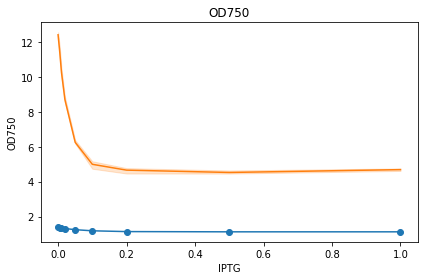

  7%|██████▌                                                                                       | 35/500 [18:04<1:31:29, 11.81s/trial, best loss: 0.386890357069524]

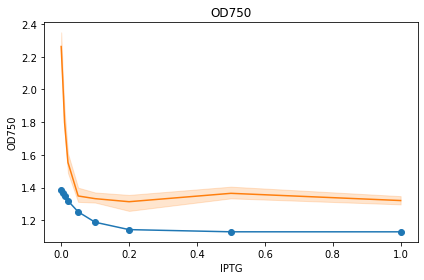

  7%|██████▊                                                                                       | 36/500 [19:06<3:28:26, 26.95s/trial, best loss: 0.386890357069524]

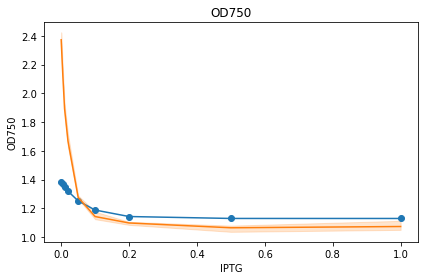

  7%|██████▉                                                                                       | 37/500 [20:09<4:51:07, 37.73s/trial, best loss: 0.386890357069524]

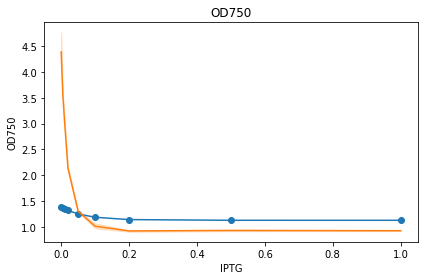

  8%|███████▏                                                                                      | 38/500 [21:12<5:48:02, 45.20s/trial, best loss: 0.386890357069524]

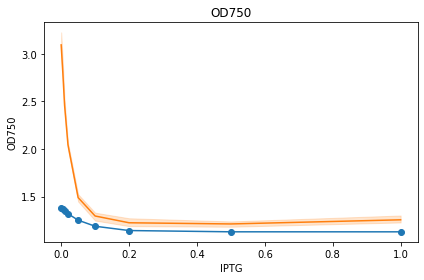

  8%|███████▎                                                                                      | 39/500 [22:14<6:26:47, 50.34s/trial, best loss: 0.386890357069524]

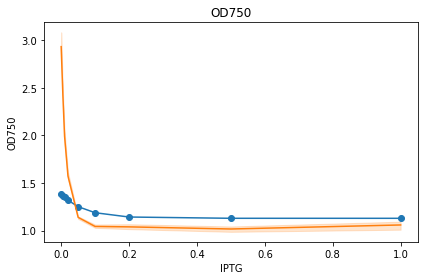

  8%|███████▌                                                                                      | 40/500 [23:17<6:54:03, 54.01s/trial, best loss: 0.386890357069524]

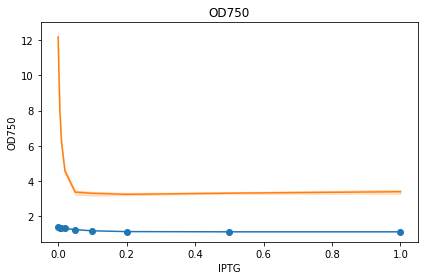

  8%|███████▋                                                                                      | 41/500 [24:24<7:23:24, 57.96s/trial, best loss: 0.386890357069524]

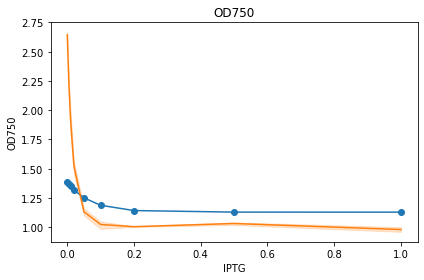

  8%|███████▉                                                                                      | 42/500 [25:27<7:35:19, 59.65s/trial, best loss: 0.386890357069524]

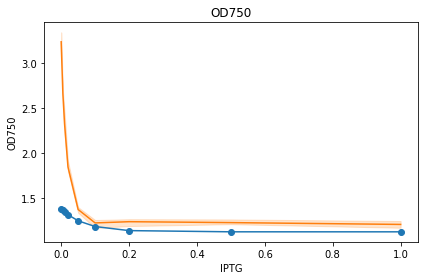

  9%|████████                                                                                      | 43/500 [26:30<7:41:06, 60.54s/trial, best loss: 0.386890357069524]

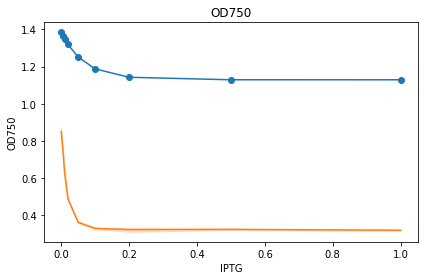

  9%|████████▎                                                                                     | 44/500 [27:31<7:41:15, 60.69s/trial, best loss: 0.386890357069524]

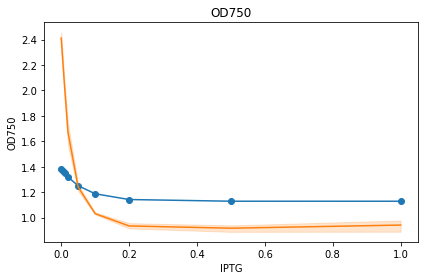

  9%|████████▋                                                                                     | 46/500 [28:34<5:24:51, 42.93s/trial, best loss: 0.386890357069524]

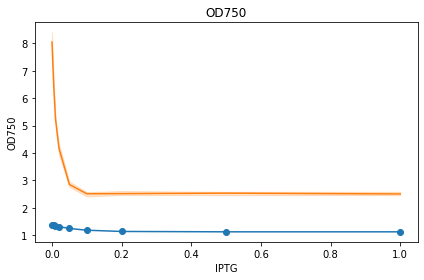

  9%|████████▊                                                                                     | 47/500 [29:39<6:15:00, 49.67s/trial, best loss: 0.386890357069524]

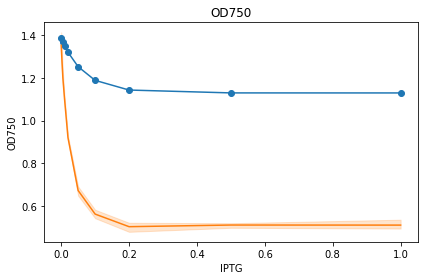

 10%|█████████▏                                                                                    | 49/500 [30:41<4:40:30, 37.32s/trial, best loss: 0.386890357069524]

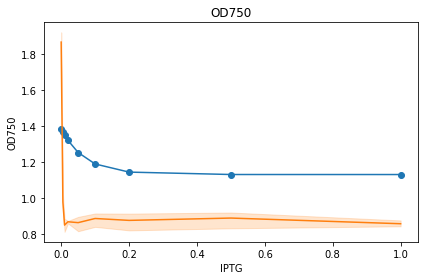

 10%|█████████▍                                                                                  | 51/500 [31:43<3:54:00, 31.27s/trial, best loss: 0.38489739056822436]

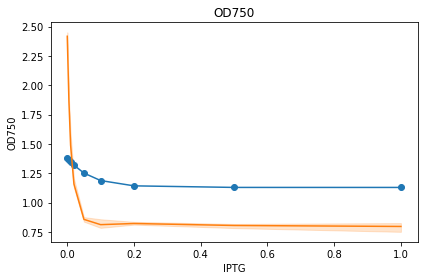

 10%|█████████▌                                                                                  | 52/500 [32:44<5:02:03, 40.45s/trial, best loss: 0.38489739056822436]

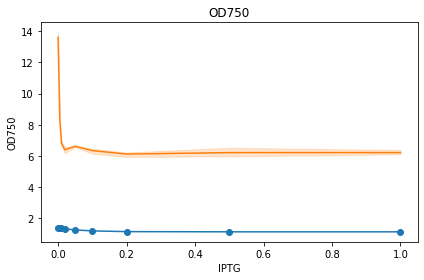

 11%|█████████▉                                                                                  | 54/500 [33:54<4:15:25, 34.36s/trial, best loss: 0.38489739056822436]

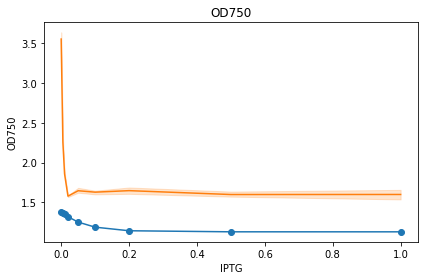

 11%|██████████                                                                                  | 55/500 [34:58<5:20:34, 43.22s/trial, best loss: 0.38489739056822436]

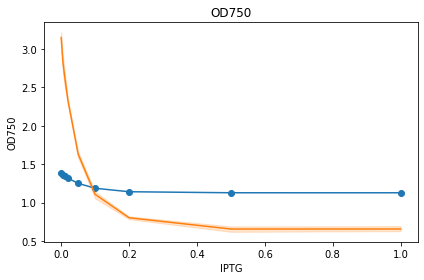

 11%|██████████▎                                                                                 | 56/500 [36:01<6:04:22, 49.24s/trial, best loss: 0.38489739056822436]

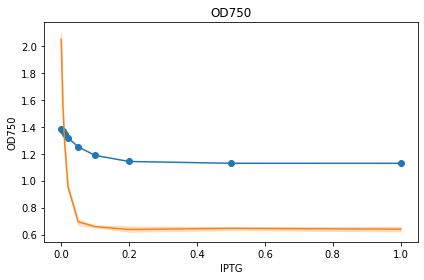

 11%|██████████▍                                                                                 | 57/500 [37:03<6:31:22, 53.01s/trial, best loss: 0.38489739056822436]

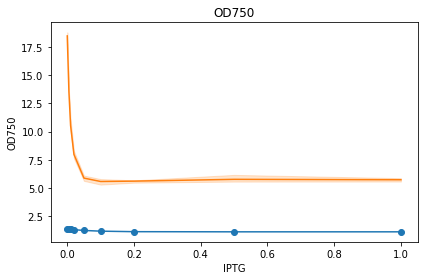

 12%|██████████▋                                                                                 | 58/500 [38:14<7:11:02, 58.51s/trial, best loss: 0.38489739056822436]

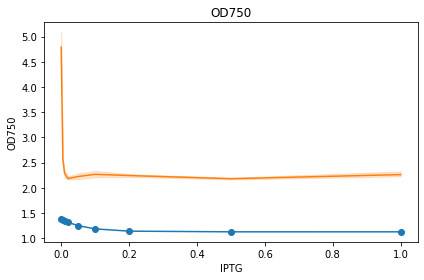

 12%|██████████▊                                                                                 | 59/500 [39:17<7:20:25, 59.92s/trial, best loss: 0.38489739056822436]

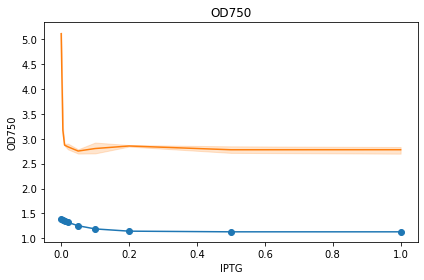

 12%|███████████                                                                                 | 60/500 [40:22<7:30:26, 61.42s/trial, best loss: 0.38489739056822436]

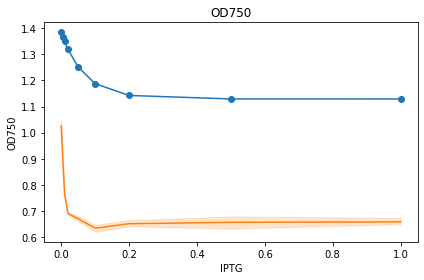

 12%|███████████▏                                                                                | 61/500 [41:24<7:30:33, 61.58s/trial, best loss: 0.38489739056822436]

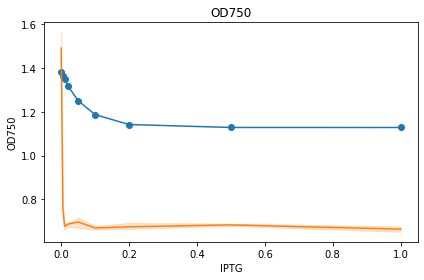

 12%|███████████▍                                                                                | 62/500 [42:26<7:29:50, 61.62s/trial, best loss: 0.38489739056822436]

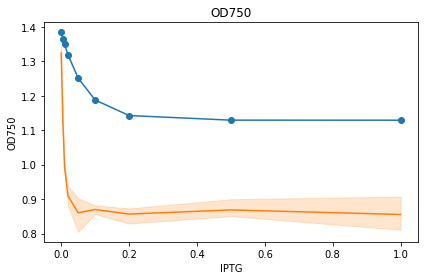

 13%|███████████▋                                                                                 | 63/500 [43:28<7:29:18, 61.69s/trial, best loss: 0.3041955108168476]

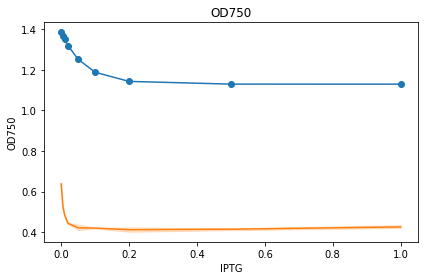

 13%|███████████▉                                                                                 | 64/500 [44:29<7:27:08, 61.53s/trial, best loss: 0.3041955108168476]

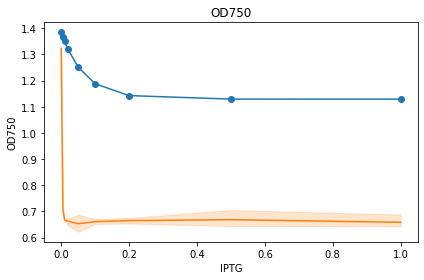

 13%|████████████                                                                                 | 65/500 [45:31<7:27:51, 61.77s/trial, best loss: 0.3041955108168476]

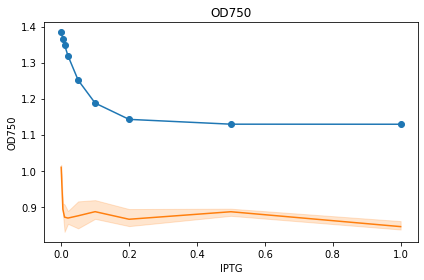

 13%|████████████▎                                                                                | 66/500 [46:33<7:26:40, 61.75s/trial, best loss: 0.3041955108168476]

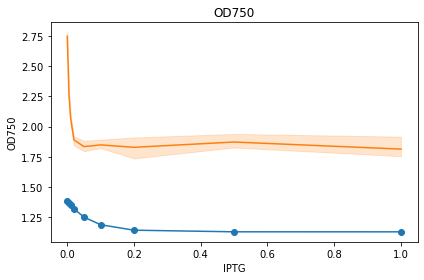

 13%|████████████▍                                                                                | 67/500 [47:36<7:29:01, 62.22s/trial, best loss: 0.3041955108168476]

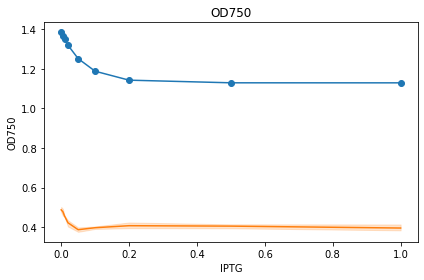

 14%|████████████▋                                                                                | 68/500 [48:37<7:25:14, 61.84s/trial, best loss: 0.3041955108168476]

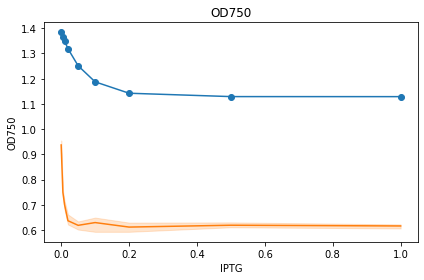

 14%|█████████████                                                                                | 70/500 [49:38<5:09:37, 43.20s/trial, best loss: 0.3041955108168476]

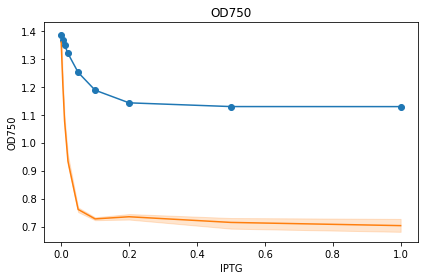

 14%|█████████████▏                                                                               | 71/500 [50:40<5:48:51, 48.79s/trial, best loss: 0.3041955108168476]

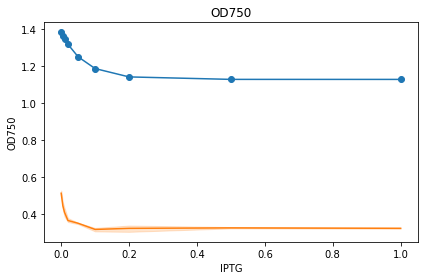

 14%|█████████████▍                                                                               | 72/500 [51:41<6:14:08, 52.45s/trial, best loss: 0.3041955108168476]

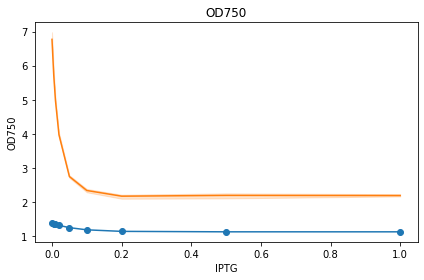

 15%|█████████████▌                                                                               | 73/500 [52:46<6:40:17, 56.25s/trial, best loss: 0.3041955108168476]

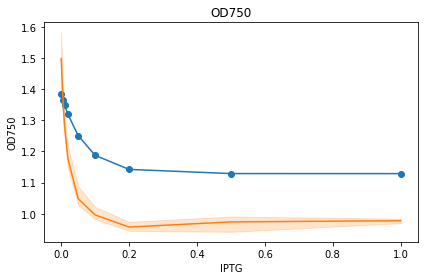

 15%|█████████████▊                                                                              | 75/500 [53:49<4:48:05, 40.67s/trial, best loss: 0.14549150023026733]

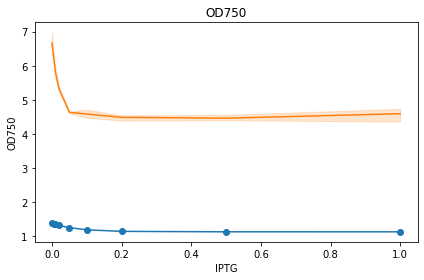

 15%|██████████████▏                                                                             | 77/500 [54:57<4:01:21, 34.23s/trial, best loss: 0.14549150023026733]

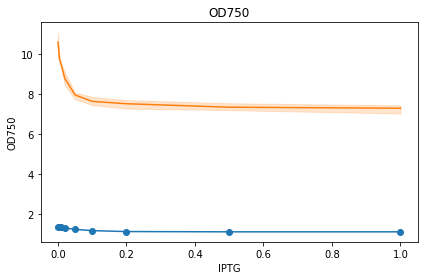

 16%|███████████████                                                                             | 82/500 [56:08<1:16:41, 11.01s/trial, best loss: 0.14549150023026733]

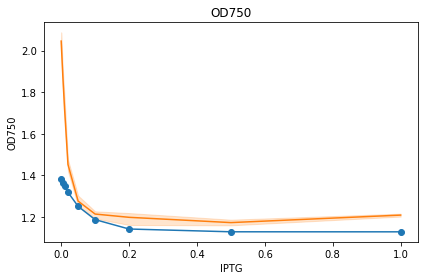

 17%|███████████████▍                                                                            | 84/500 [57:11<2:08:38, 18.56s/trial, best loss: 0.14549150023026733]

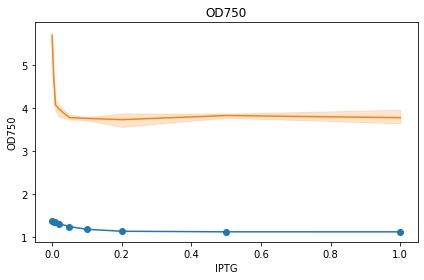

 17%|███████████████▋                                                                            | 85/500 [58:17<3:46:21, 32.73s/trial, best loss: 0.14549150023026733]

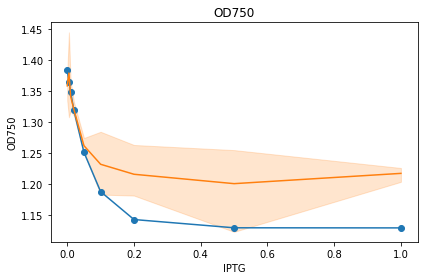

 17%|████████████████                                                                            | 87/500 [59:19<3:20:15, 29.09s/trial, best loss: 0.04649468920857261]

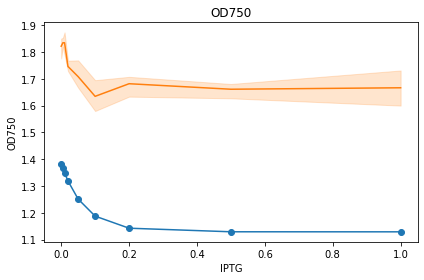

 18%|████████████████                                                                          | 89/500 [1:00:27<3:15:28, 28.54s/trial, best loss: 0.04649468920857261]

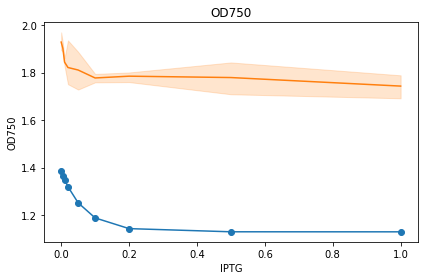

 18%|████████████████▏                                                                         | 90/500 [1:01:37<4:39:35, 40.92s/trial, best loss: 0.04649468920857261]

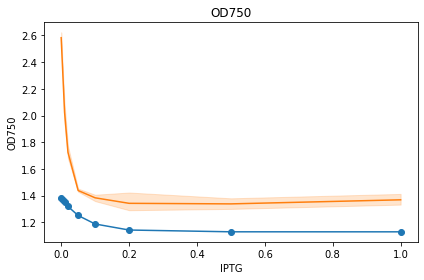

 18%|████████████████▍                                                                         | 91/500 [1:02:39<5:23:14, 47.42s/trial, best loss: 0.04649468920857261]

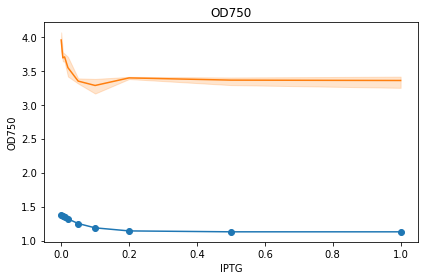

 18%|████████████████▌                                                                         | 92/500 [1:03:51<6:12:56, 54.84s/trial, best loss: 0.04649468920857261]

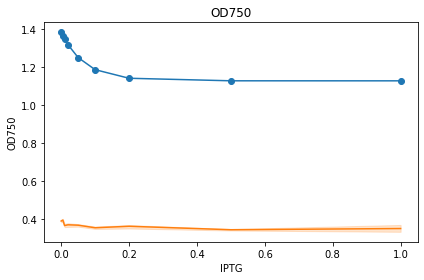

 19%|████████████████▉                                                                         | 94/500 [1:05:02<4:42:42, 41.78s/trial, best loss: 0.04649468920857261]

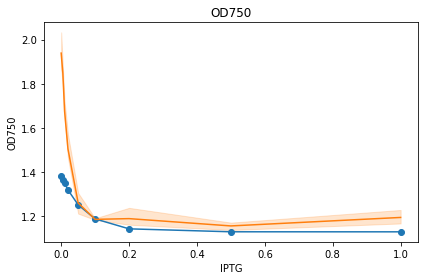

 19%|█████████████████                                                                         | 95/500 [1:06:17<5:48:46, 51.67s/trial, best loss: 0.04649468920857261]

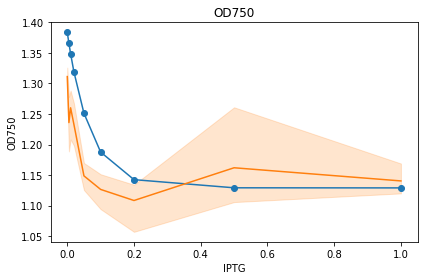

 19%|█████████████████▎                                                                        | 96/500 [1:07:32<6:34:04, 58.53s/trial, best loss: 0.04649468920857261]

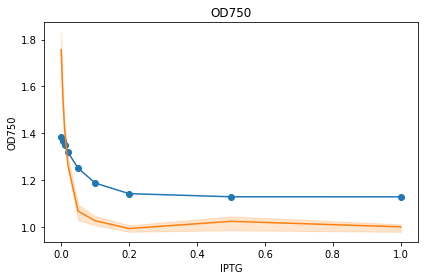

 20%|█████████████████▊                                                                        | 99/500 [1:08:47<3:28:36, 31.21s/trial, best loss: 0.04649468920857261]

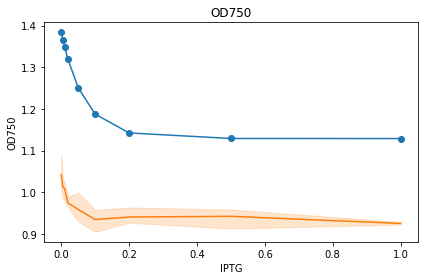

 20%|██████████████████▏                                                                      | 102/500 [1:10:02<2:24:16, 21.75s/trial, best loss: 0.04649468920857261]

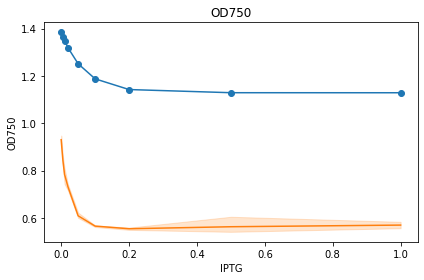

 21%|██████████████████▎                                                                      | 103/500 [1:11:15<4:06:50, 37.30s/trial, best loss: 0.04649468920857261]

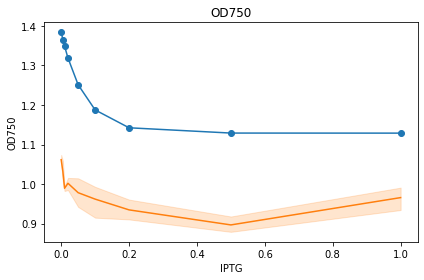

 21%|██████████████████▌                                                                      | 104/500 [1:12:24<5:08:25, 46.73s/trial, best loss: 0.04649468920857261]

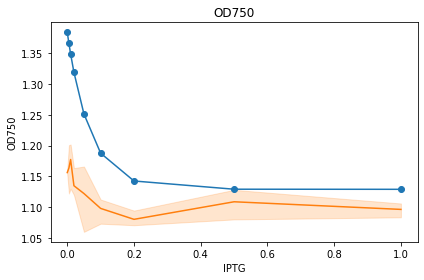

 21%|██████████████████▋                                                                      | 105/500 [1:13:26<5:38:05, 51.36s/trial, best loss: 0.04649468920857261]

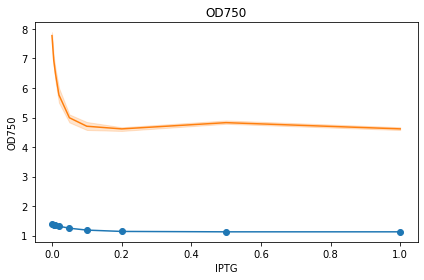

 21%|██████████████████▊                                                                      | 106/500 [1:14:37<6:15:24, 57.17s/trial, best loss: 0.04649468920857261]

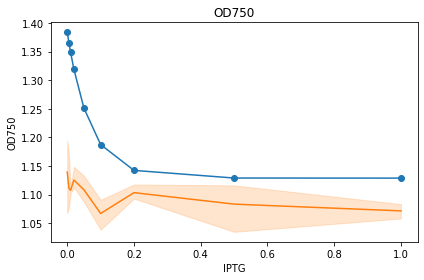

 21%|███████████████████                                                                      | 107/500 [1:15:51<6:48:05, 62.31s/trial, best loss: 0.04649468920857261]

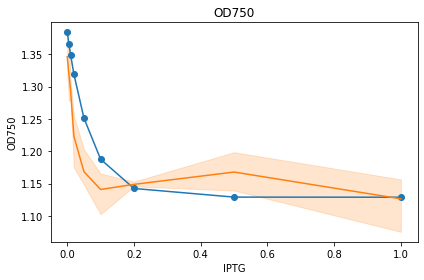

 22%|███████████████████▏                                                                     | 108/500 [1:17:05<7:09:07, 65.68s/trial, best loss: 0.04649468920857261]

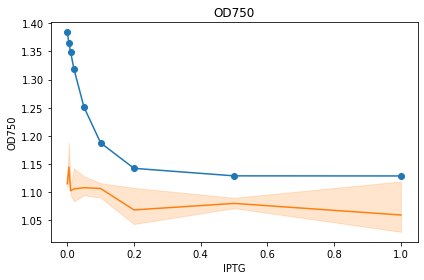

 22%|███████████████████▌                                                                     | 110/500 [1:18:20<5:11:19, 47.90s/trial, best loss: 0.04649468920857261]

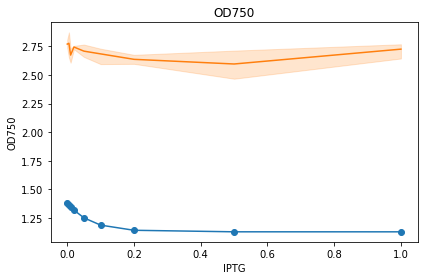

 22%|███████████████████▉                                                                     | 112/500 [1:19:36<4:15:45, 39.55s/trial, best loss: 0.04649468920857261]

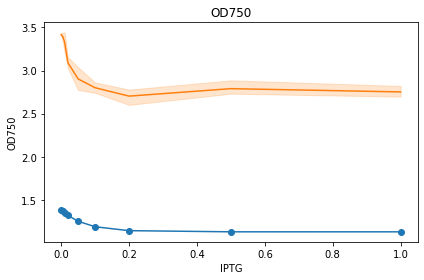

 23%|████████████████████▍                                                                    | 115/500 [1:20:49<2:36:19, 24.36s/trial, best loss: 0.04649468920857261]

job exception: [Errno 2] No such file or directory: 'runs/Run_100_0_5.00e-01_1_2022-04-05_251965/Results/biomass.csv'



 23%|████████████████████                                                                   | 115/500 [3:11:51<10:42:18, 100.10s/trial, best loss: 0.04649468920857261]


In [ ]:
od_space = {
    'a' : hp.uniform('a', 1e-3, 1e0),
    'tau' : hp.uniform('tau',1e-3,1e-1),
    'c' : hp.uniform('c',1e-3,1e1),
}
od_trials = Trials()


od_best = fmin(
    fn=od_objective, # Objective Function to optimize
    space=od_space, # Hyperparameter's Search Space
    algo=atpe.suggest, # Optimization algorithm
    max_evals=500,
    trials = od_trials # Number of optimization attempts
)

print(od_best)

In [16]:
print(od_best)

NameError: name 'od_best' is not defined

ERROR! Session/line number was not unique in database. History logging moved to new session 30


In [ ]:
suc_space = {
    'a' : od_best['a'],
    'tau' : od_best['tau'],
    'c' : od_best['c'],
    'a2' : hp.uniform('a2', 1e-3, 1e1),
    'tau2' : hp.uniform('tau2',1e-3,1e-1),
    'c2' : hp.uniform('c2',1e-3,1e1),
}
suc_trials = Trials()


suc_best = fmin(
    fn=suc_objective, # Objective Function to optimize
    space=suc_space, # Hyperparameter's Search Space
    algo=tpe.suggest, # Optimization algorithm
    max_evals=1000,
    trials = suc_trials # Number of optimization attempts
)

print(suc_best)

In [ ]:
#convergence = pd.DataFrame([pd.Series(t["result"]["loss"]) for t in trials])

In [115]:
BASE_DIR = Path(f'runs/')
folders = [path for path in BASE_DIR.iterdir() if path.is_dir()]

#Extract output

tmp=Parallel(n_jobs=-1)(delayed(collect_data)(folder) for folder in folders)
data = pd.concat(tmp,ignore_index=True)
df = data.loc[(data.Hours == data.Hours.iloc[-1])]
df.sort_values(by='IPTG',inplace=True)
df.reset_index(inplace=True)

/tmp/ipykernel_28235/256604372.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.sort_values(by='IPTG',inplace=True)


In [116]:
df

,index,OD750,Hours,Sucrose,IPTG
0,86,611.797876,11.944444,4.395685e-15,0.000
1,1143,590.385487,11.944444,2.929793e-20,0.005
2,1187,606.527434,11.944444,2.921414e-20,0.005
3,1231,585.649204,11.944444,2.618837e-19,0.005
4,456,552.442124,11.944444,3.816360e-20,0.010
5,500,567.358230,11.944444,2.921414e-20,0.010
6,544,525.850619,11.944444,2.921414e-20,0.010
7,774,539.526372,11.944444,3.393284e-20,0.020
8,818,507.873982,11.944444,3.026930e-20,0.020
9,730,534.037522,11.944444,2.921443e-20,0.020


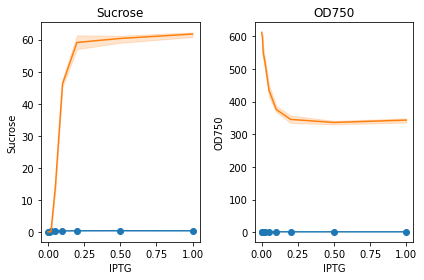

In [117]:
f, ax = plt.subplots(ncols=2)
ax[0].set_title('Sucrose')
ax[0].plot(test_data.IPTG,test_data.Sucrose,marker='o')
sns.lineplot(x='IPTG',y='Sucrose',ax=ax[0],data=df)
ax[1].set_title('OD750')
ax[1].plot(test_data.IPTG,test_data.OD750,marker='o')
sns.lineplot(x='IPTG',y='OD750',ax=ax[1],data=df)
f.tight_layout()
plt.show()
